<a href="https://colab.research.google.com/github/palkakrzysiek/trainings-generator-python/blob/main/progression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plugin to upload/download workouts
https://chrome.google.com/webstore/detail/share-your-garmin-connect/kdpolhnlnkengkmfncjdbfdehglepmff

In [494]:
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [495]:

def warm_up(time, step_order):
    return {
        "type": "ExecutableStepDTO",
        "stepId": 2698638070,
        "stepOrder": step_order,
        "stepType": {
            "stepTypeId": 1,
            "stepTypeKey": "warmup",
            "displayOrder": 1
        },
        "description": "A warm up note",
        "endCondition": {
            "conditionTypeId": 2,
            "conditionTypeKey": "time",
            "displayOrder": 2,
            "displayable": True
        },
        "endConditionValue": time,
        "targetType": {
            "workoutTargetTypeId": 1,
            "workoutTargetTypeKey": "no.target",
            "displayOrder": 1
        }
    }


def run(distance, min_speed_mps, max_speed_mps, description, step_order):
    return {
        "type": "ExecutableStepDTO",
        "stepId": 2698638071 + step_order,
        "stepOrder": step_order,
        "stepType": {
            "stepTypeId": 3,
            "stepTypeKey": "interval",
            "displayOrder": 3
        },
        "description": description,
        "endCondition": {
            "conditionTypeId": 3,
            "conditionTypeKey": "distance",
            "displayOrder": 3,
            "displayable": True
        },
        "endConditionValue": distance,
        "preferredEndConditionUnit": {
            "unitId": 2,
            "unitKey": "kilometer",
            "factor": 100000
        },
        "targetType": {
            "workoutTargetTypeId": 6,
            "workoutTargetTypeKey": "pace.zone",
            "displayOrder": 6
        },
        "targetValueOne": min_speed_mps,
        "targetValueTwo": max_speed_mps
    }

In [496]:
def workout_template(name, description, steps, estimated_duration_in_secs, estimated_distance_in_meters):
    return {
    "workoutId": 388473607,
    "ownerId": 66888980,
    "workoutName": name,
    "description": description,
    "updatedDate": "2021-09-12T14:08:55.0",
    "createdDate": "2021-09-12T14:08:55.0",
    "sportType": {
        "sportTypeId": 1,
        "sportTypeKey": "running",
        "displayOrder": 1
    },
    "estimatedDurationInSecs": estimated_duration_in_secs,
    "estimatedDistanceInMeters": estimated_distance_in_meters,
    "workoutSegments": [
        {
            "segmentOrder": 1,
            "sportType": {
                "sportTypeId": 1,
                "sportTypeKey": "running",
                "displayOrder": 1
            },
            "workoutSteps": steps
        }
    ],
    "shared": False
}

In [497]:
def minpkm_to_mps(val):
    return 1000 / val / 60

In [498]:
target_distance = 18000
split_distance = 500
splits_number = int(target_distance/split_distance)
total_distance = split_distance * splits_number

start_pace_minpkm = 7
end_pace_minpkm = 6

pace_toleration = 0.33334



-5.714285714285714e-05
    distance      pace       mps  lap  lap_time_sec   total_time    time_left  \
0        0.0  7.000000  2.380952    1    210.000000   210.000000  7020.000000   
1      500.0  6.971429  2.390710    2    209.142857   419.142857  6840.000000   
2     1000.0  6.942857  2.400549    3    208.285714   627.428571  6659.142857   
3     1500.0  6.914286  2.410468    4    207.428571   834.857143  6477.428571   
4     2000.0  6.885714  2.420470    5    206.571429  1041.428571  6294.857143   
5     2500.0  6.857143  2.430556    6    205.714286  1247.142857  6111.428571   
6     3000.0  6.828571  2.440725    7    204.857143  1452.000000  5927.142857   
7     3500.0  6.800000  2.450980    8    204.000000  1656.000000  5742.000000   
8     4000.0  6.771429  2.461322    9    203.142857  1859.142857  5556.000000   
9     4500.0  6.742857  2.471751   10    202.285714  2061.428571  5369.142857   
10    5000.0  6.714286  2.482270   11    201.428571  2262.857143  5181.428571   
11   

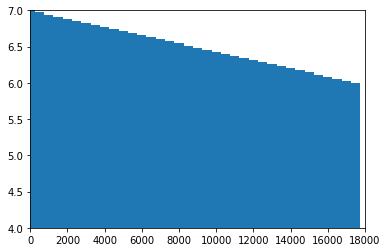

In [499]:

slope = (end_pace_minpkm - start_pace_minpkm) / (total_distance - split_distance)
# - split_distance to have the last split at end disntance

print(slope)

x = np.arange(0, total_distance, split_distance)
y = start_pace_minpkm + slope * x

df = pd.DataFrame(np.array([x, y]).transpose(), columns=['distance', 'pace'])

df['mps'] = 1000 / df['pace'] / 60

df['lap'] = df.index + 1

# df['lap_time_sec'] = df['mps'].apply(lambda mps: datetime.timedelta(seconds=split_distance / mps))
df['lap_time_sec'] = split_distance / df['mps']

df['total_time'] = df['lap_time_sec'].cumsum()

df['time_left'] = df['total_time'].values[::-1]

def format_secs(value):
    h = int(value / 60 / 60)
    m = int((value / 60) % 60)
    s = int(value % 60)
    if h > 0:
        return "{:d}:{:02d}:{:02d}".format(h,m,s)
    else:
        return "{:02d}:{:02d}".format(m,s)


df['formatted_time_left'] = df['time_left'].apply(format_secs)

df['laps_left'] = range(len(df), 0, -1)

def format_pace(input):
    min = int(input)
    sec = int((input % 1) * 60)
    return "{:d}:{:02d}".format(min, sec)

df['formatted_pace'] = df['pace'].apply(format_pace)

df['distance_left'] = total_distance - df['distance']

def format_meters_to_km(input):
    return "{:.2f}".format(input/1000.0)

df['formatted_distance_left'] = df['distance_left'].apply(lambda dis: format_meters_to_km(dis))

df['min_pace'] = df['pace'] + pace_toleration
df['max_pace'] = df['pace'] - pace_toleration

df['min_speed_mps'] = df['min_pace'].apply(minpkm_to_mps)
df['max_speed_mps'] = df['max_pace'].apply(minpkm_to_mps)

df['formatted_min_pace'] = df['min_pace'].apply(format_pace)
df['formatted_max_pace'] = df['max_pace'].apply(format_pace)

df['split_time'] = split_distance

df['description'] = df.apply(lambda row: "left: {:d} laps |\n{:s} km | {:s}".format(row['laps_left'], row['formatted_distance_left'], row['formatted_time_left']), axis=1)



# ,
print(df)

fig = plt.figure()


plt.bar(x,y,width=split_distance)
plt.xlim(0, total_distance)
plt.ylim(4, max(start_pace_minpkm, end_pace_minpkm))
plt.show()


In [500]:
steps = list(df.apply(lambda row: run(distance=split_distance, min_speed_mps=row['min_speed_mps'], max_speed_mps=row['max_speed_mps'], description=row['description'], step_order=row['lap'] + 1), axis=1).values)

steps.insert(0, warm_up(
    time=120,
    step_order=1
))


print(steps)

name = "{:s}km {:s}->{:s}".format(format_meters_to_km(total_distance), format_pace(start_pace_minpkm), format_pace(end_pace_minpkm))
print(name)
description = str(split_distance) + "m * " + str(splits_number) + " splits, est. time " + df['formatted_time_left'][0]
print(description)

est_time_sec = int(df['time_left'][0])

workout = workout_template(
    name=name,
    description=description,
    steps=steps,
    estimated_duration_in_secs=est_time_sec,
    estimated_distance_in_meters=total_distance
)


json.dumps(workout)

[{'type': 'ExecutableStepDTO', 'stepId': 2698638070, 'stepOrder': 1, 'stepType': {'stepTypeId': 1, 'stepTypeKey': 'warmup', 'displayOrder': 1}, 'description': 'A warm up note', 'endCondition': {'conditionTypeId': 2, 'conditionTypeKey': 'time', 'displayOrder': 2, 'displayable': True}, 'endConditionValue': 120, 'targetType': {'workoutTargetTypeId': 1, 'workoutTargetTypeKey': 'no.target', 'displayOrder': 1}}, {'type': 'ExecutableStepDTO', 'stepId': 2698638073, 'stepOrder': 2, 'stepType': {'stepTypeId': 3, 'stepTypeKey': 'interval', 'displayOrder': 3}, 'description': 'left: 36 laps |\n18.00 km | 1:57:00', 'endCondition': {'conditionTypeId': 3, 'conditionTypeKey': 'distance', 'displayOrder': 3, 'displayable': True}, 'endConditionValue': 500, 'preferredEndConditionUnit': {'unitId': 2, 'unitKey': 'kilometer', 'factor': 100000}, 'targetType': {'workoutTargetTypeId': 6, 'workoutTargetTypeKey': 'pace.zone', 'displayOrder': 6}, 'targetValueOne': 2.272725206613449, 'targetValueTwo': 2.500002500002

'{"workoutId": 388473607, "ownerId": 66888980, "workoutName": "18.00km 7:00->6:00", "description": "500m * 36 splits, est. time 1:57:00", "updatedDate": "2021-09-12T14:08:55.0", "createdDate": "2021-09-12T14:08:55.0", "sportType": {"sportTypeId": 1, "sportTypeKey": "running", "displayOrder": 1}, "estimatedDurationInSecs": 7020, "estimatedDistanceInMeters": 18000, "workoutSegments": [{"segmentOrder": 1, "sportType": {"sportTypeId": 1, "sportTypeKey": "running", "displayOrder": 1}, "workoutSteps": [{"type": "ExecutableStepDTO", "stepId": 2698638070, "stepOrder": 1, "stepType": {"stepTypeId": 1, "stepTypeKey": "warmup", "displayOrder": 1}, "description": "A warm up note", "endCondition": {"conditionTypeId": 2, "conditionTypeKey": "time", "displayOrder": 2, "displayable": true}, "endConditionValue": 120, "targetType": {"workoutTargetTypeId": 1, "workoutTargetTypeKey": "no.target", "displayOrder": 1}}, {"type": "ExecutableStepDTO", "stepId": 2698638073, "stepOrder": 2, "stepType": {"stepTyp